###### Università degli Studi di Milano, Data Science and Economics Master Degree

# Policy-based methods
## An overview of policy gradient methods

### Alfio Ferrara

## Policy Gradient Theorem
The intuition on the base of policy gradient is that policy gradient methods transform the policy output into a probability distribution, from which the agent samples to select an action. These methods adjust the policy parameters, continuously refining the probability distribution at each iteration. As a result, the updated distribution increases the likelihood of selecting actions that yield higher rewards.

The policy gradient algorithm calculates the gradient of the expected return concerning the policy parameters. By adjusting these parameters in the direction of the gradient, the agent enhances the probability of choosing actions that lead to greater rewards over time.

In essence, actions that previously produced favorable outcomes become increasingly probable, gradually optimizing the policy to maximize long-term rewards.

So, concerning a trajectory and an initial state $s_0$, we need a way to compute the gradient of the expected total reward from state $s_0$ with respect to the parameters. The policy gradient theorem states that:

$$
\nabla_{\pi} \left[ G_0 \mid s_0  \right] \propto \sum\limits_{s} \mu(s) \sum\limits_{s} Q(s, a) \nabla \pi(a \mid s; \mathbf{w})
$$

On which we use log probabilities to stabilize training by converting multiplicative probability updates into additive updates

$$
\nabla_{\mathbf{w}} J(\mathbf{w}) = \mathbb{E}_{\pi} \left[ \nabla_{\mathbf{w}} \log \pi(a \mid s; \mathbf{w}) Q(s, a)\right]
$$

where $\mu(s)$ is the probability of being in state $s$.

## REINFORCE
REINFORCE is a Monte Carlo algorithm which is defined by the following steps

1. Compute episodic trajectories $(s_0, a_0, r_1, s_1, a_1, s_2, \dots)$
2. Discounted rewards
$$
R_t = \sum\limits_{k=t}^{T} \gamma^{k-t} r_k
$$
3. Compute the policy gradient and update the parameters
$$
\mathbf{w} \leftarrow \mathbf{w} + \alpha \sum\limits_{t=0}^{T} R_t \nabla_{\mathbf{w}} \log \pi(a_t \mid s_t; \mathbf{w})
$$


### Policy gradient and continuous action space

#### [Car Racing](https://gymnasium.farama.org/environments/box2d/car_racing/)

The reward is -0.1 every frame and +1000/N for every track tile visited, where N is the total number of tiles visited in the track. For example, if you have finished in 732 frames, your reward is 1000 - 0.1*732 = 926.8 points.

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

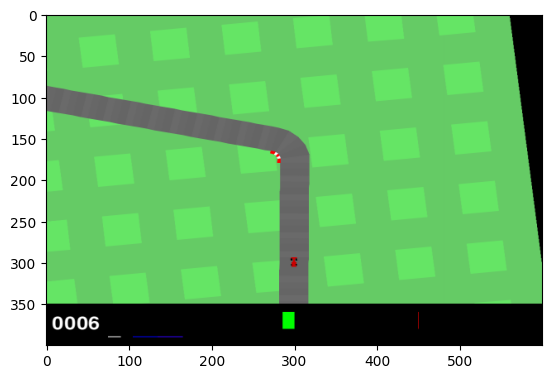

Action: [-0.60278213  0.10986049  0.8282265 ] - Total Reward: 6.6519379844961275


In [2]:
env = gym.make("CarRacing-v3", render_mode="rgb_array", lap_complete_percent=0.95, domain_randomize=False, continuous=True)

state, info = env.reset()

def policy(state: int):
    return env.action_space.sample()

end_episode = False 
max_count = 10
total_reward = 0
while not end_episode:
    if max_count < 0:
        break 
    action = policy(state)
    s_prime, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    end_episode = terminated or truncated
    clear_output(wait=True)
    plt.imshow(env.render())
    plt.show()
    print(f"Action: {action} - Total Reward: {total_reward}")
    #time.sleep(.1)
    state = s_prime
    max_count -= 1
    
env.close()

### Reinforce implementation
We use an Advantage function to reduce variance, normalize rewards and perform batch updates. See [REINFORCE](./gymbase/reinforce.py)

In [3]:
from gymbase.reinforce import PolicyGradientAgent, preprocess_frame
from tqdm.notebook import tqdm

In [4]:
LEARNING_RATE = 3e-4
GAMMA = 0.99 
EPISODES = 3000
BATCH_SIZE = 10
HIDDEN_UNITS = 256

We have continuous actions (steering, acceleration, braking)

In [5]:
def train(env: gym.Env, agent: PolicyGradientAgent, episodes: int):

    total_rewards = []

    for episode in tqdm(range(episodes), total=episodes):
        state, _ = env.reset()
        state = preprocess_frame(state)
        total_reward = 0
        done = False

        while not done:
            action, log_prob = agent.select_action(state)
            next_state, reward, term, trunc, _ = env.step(action)
            next_state = preprocess_frame(next_state)
            agent.store_outcome(log_prob, reward, state)
            state = next_state
            total_reward += reward
            done = term or trunc
            if done:
                break
        # Update policy every BATCH_SIZE episodes
        if episode % BATCH_SIZE == 0:
            agent.update_policy()
        total_rewards.append(total_reward)

    env.close()
    return total_rewards

**DISCLAIMER**: training this architecture on Car Racing is super slow even on CUDA. The following code is just a snipped for showing the loop.

In [7]:
env = gym.make("CarRacing-v3", render_mode="rgb_array", lap_complete_percent=0.95, domain_randomize=False, continuous=True)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=100)

action_dim = env.action_space.shape[0] 
agent = PolicyGradientAgent(action_dim)

EPISODES = 10

rewards = train(env=env, agent=agent, episodes=EPISODES)


  0%|          | 0/10 [00:00<?, ?it/s]

In [8]:
import seaborn as sns

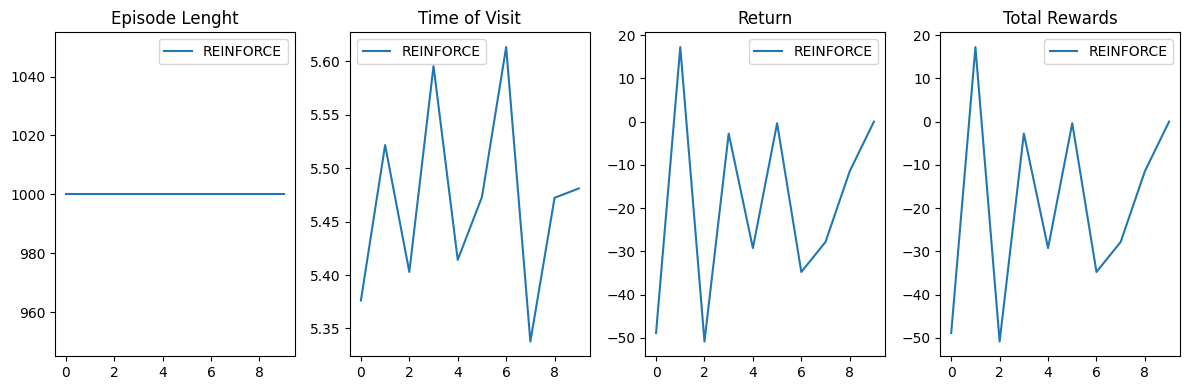

In [9]:
mlen, mtime, mret = env.length_queue, env.time_queue, env.return_queue

fig, ax = plt.subplots(figsize=(12, 4), ncols=4, nrows=1)
sns.lineplot(x=range(len(mlen)), y=mlen, ax=ax[0], label="REINFORCE")
sns.lineplot(x=range(len(mtime)), y=mtime, ax=ax[1], label="REINFORCE")
sns.lineplot(x=range(len(mret)), y=mret, ax=ax[2], label="REINFORCE")
sns.lineplot(x=range(len(rewards)), y=rewards, ax=ax[3], label="REINFORCE")
ax[0].set_title("Episode Lenght")
ax[1].set_title("Time of Visit")
ax[2].set_title("Return")
ax[3].set_title("Total Rewards")
plt.tight_layout()
plt.show()

In [10]:
import torch

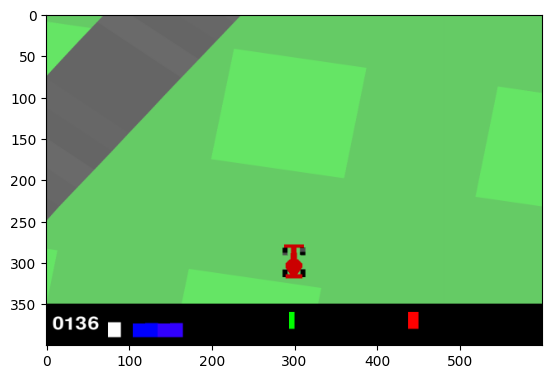

Action: [-0.03712647  0.0784639  -0.22940564] - Total Reward: 136.11111111111495


In [11]:
env = gym.make("CarRacing-v3", render_mode="rgb_array", lap_complete_percent=0.95, domain_randomize=False, continuous=True)

device = torch.device("mps" if torch.mps.is_available() else "cpu")

state, info = env.reset()
state = preprocess_frame(state)

end_episode = False 
max_count = 1000
total_reward = 0
while not end_episode:
    if max_count < 0:
        break 
    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
    with torch.no_grad():
        mean, _ = agent.policy(state_tensor)
    action = mean.cpu().numpy().squeeze()
    s_prime, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    end_episode = terminated or truncated
    clear_output(wait=True)
    plt.imshow(env.render())
    plt.show()
    print(f"Action: {action} - Total Reward: {total_reward}")
    #time.sleep(.1)
    state = preprocess_frame(s_prime)
    max_count -= 1
    
env.close()